# Area of Interest 4 (AOI4) Exploratory Data Analysis

## Samuel Levin, samuel.levin@utdallas.edu

### Verify python interpreter (with necessary libraries installed), bulk import

In [1]:
import sys
sys.executable

'C:\\Users\\samle\\AppData\\Local\\ESRI\\conda\\envs\\arcgispro-pyre\\python.exe'

In [2]:
import arcpy
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd
import seaborn as sns
import scipy

### Extract AOI4 raster from AOI4 vector polygon
### Maintain raster snapping of original flight bands

In [3]:
arcpy.env.workspace = r'<PATH/TO/GDB>'

aoi4_vec = 'AOI4'
flir_stacked = 'FLIR_Stacked_float'

arcpy.env.snapRaster = flir_stacked

fliraoi4 = 'AOI4_FLIR_flt'

aoi4_extract = arcpy.sa.ExtractByMask(arcpy.Raster(flir_stacked), aoi4_vec)
aoi4_extract.save(fliraoi4)

### Cast AOI raster as 3 dimensional NumPy array, assign np.nan to NoData pixels

In [4]:
aoi4 = arcpy.RasterToNumPyArray(fliraoi4, nodata_to_value=np.nan)
aoi4.shape

(5, 665, 937)

### Confirm that all input bands in the AOI extract have the same number of non-np.nan (valid) pixels

In [5]:
for band in range(aoi4.shape[0]):
    nanmask = np.logical_not(np.isnan(aoi4[band]))
    print(aoi4[band][nanmask].shape)

(354064,)
(354064,)
(354064,)
(354064,)
(354064,)


### Build boolean mask of valid data pixels in AOI

In [6]:
np.logical_not(np.isnan(aoi4[0]))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [7]:
def buildMask(stackedbands):
    individmasks = [np.logical_not(np.isnan(stackedbands[band])) for band in range(stackedbands.shape[0])]
    mask = individmasks[0]
    for im in individmasks:
        mask = np.logical_and(mask, im)
    return mask

In [8]:
aoi4_nanmask = buildMask(aoi4)

(354064,)


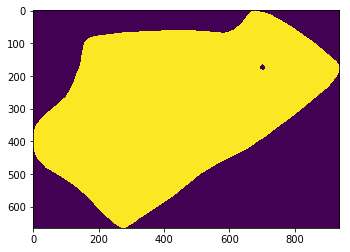

In [9]:
plt.imshow(aoi4_nanmask)
print(aoi4_nanmask[aoi4_nanmask].shape)

### Display all 5 bands of the AOI4 extract

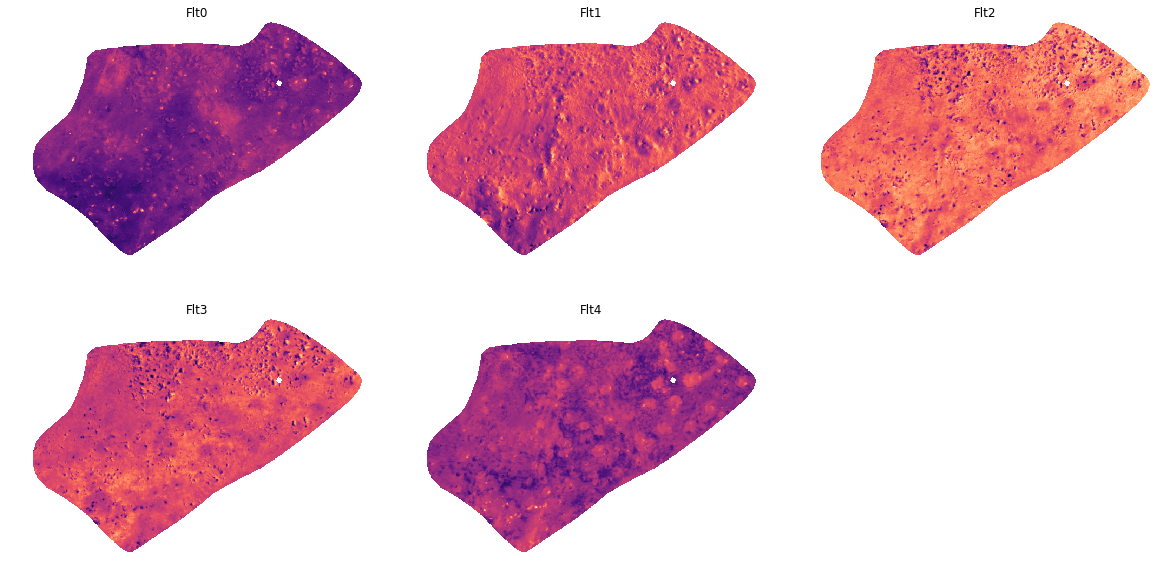

In [10]:
plt.figure(figsize=(20,10))
for band in range(aoi4.shape[0]):
    plot = band+1
    col = 3
    row = math.ceil(aoi4.shape[0]/col)
    
    plt.subplot(row, col, plot)
    plt.title('Flt{}'.format(band))
    plt.axis('off')
    plt.imshow(aoi4[band], cmap='magma')

### Essential summary statistics of each input band in the AOI

In [11]:
def rasterSummary(rast, title): 
    nanmask = np.logical_not(np.isnan(rast))
    
    plt.figure(figsize=(20,7))

    plt.subplot(1,2,1)
    plt.title(title)
    plt.axis('off')
    plt.imshow(rast, cmap='magma')
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.title('{} Histogram'.format(title))
    mini, maxi = np.nanmin(rast), np.nanmax(rast)
    plt.hist(rast[nanmask], bins=50, range=(mini,maxi), color='purple')

    plt.show()
    
    quartiles = np.percentile(rast[nanmask], [25,50,75])
    outstats = [mini, quartiles[0], quartiles[1], quartiles[2], maxi, maxi-mini, 
                quartiles[2]-quartiles[0], np.nanmean(rast), np.nanstd(rast), 
                scipy.stats.skew(rast[nanmask]), scipy.stats.kurtosis(rast[nanmask])]
    statlabel = ['Min.', 'Q1', 'Median', 'Q3', 'Max',
                'Range', 'IQ Range', 'Mean', 'Std. Dev.', 'Skewness', 'Kurtosis']
    outstats = pd.DataFrame({'Value':outstats}, index=statlabel)
    print(outstats)

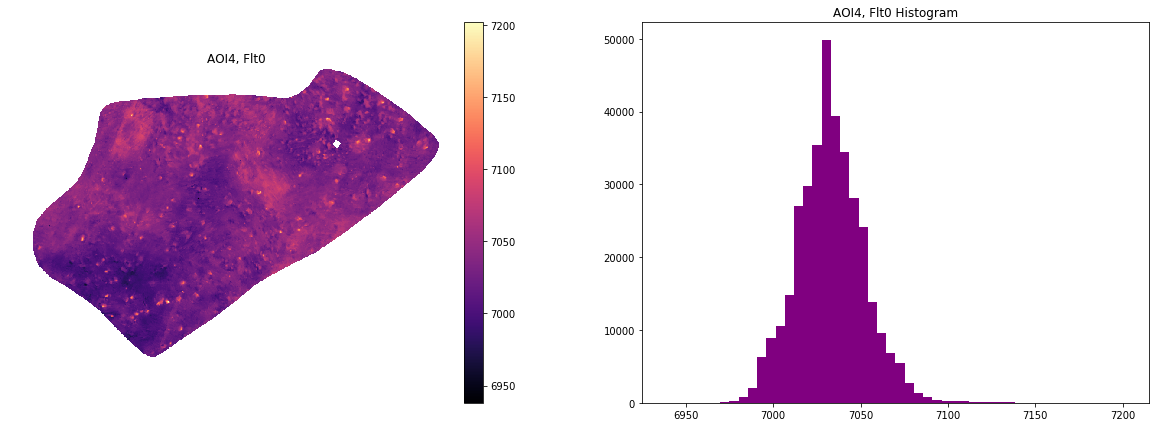

                 Value
Min.       6938.000000
Q1         7021.000000
Median     7032.000000
Q3         7045.000000
Max        7202.000000
Range       264.000000
IQ Range     24.000000
Mean       7032.969238
Std. Dev.    19.279255
Skewness      0.408648
Kurtosis      1.395171


In [12]:
rasterSummary(aoi4[0], 'AOI4, Flt0')

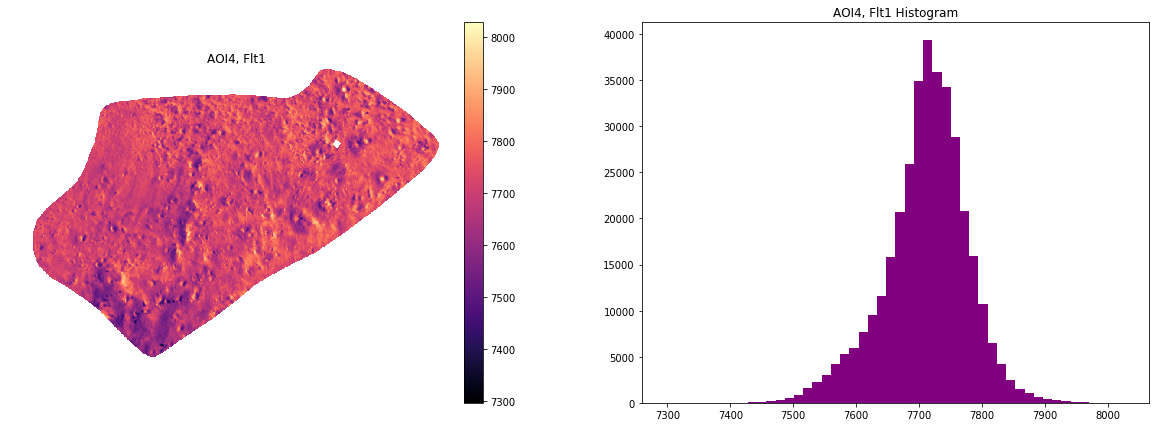

                 Value
Min.       7296.000000
Q1         7677.000000
Median     7717.000000
Q3         7753.000000
Max        8029.000000
Range       733.000000
IQ Range     76.000000
Mean       7711.197266
Std. Dev.    66.168655
Skewness     -0.461285
Kurtosis      0.964657


In [13]:
rasterSummary(aoi4[1], 'AOI4, Flt1')

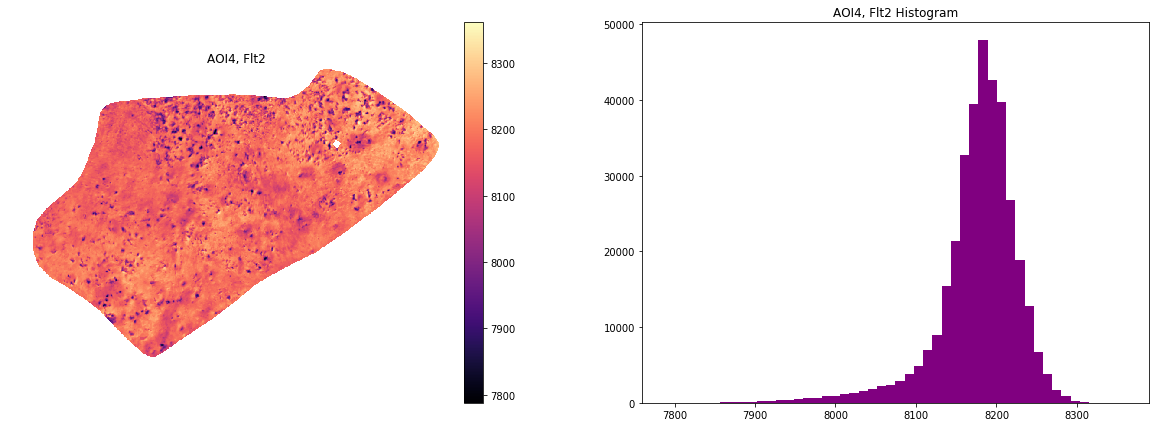

                 Value
Min.       7788.000000
Q1         8158.000000
Median     8184.000000
Q3         8207.000000
Max        8361.000000
Range       573.000000
IQ Range     49.000000
Mean       8176.909668
Std. Dev.    50.918663
Skewness     -1.694299
Kurtosis      5.530632


In [14]:
rasterSummary(aoi4[2], 'AOI4, Flt2')

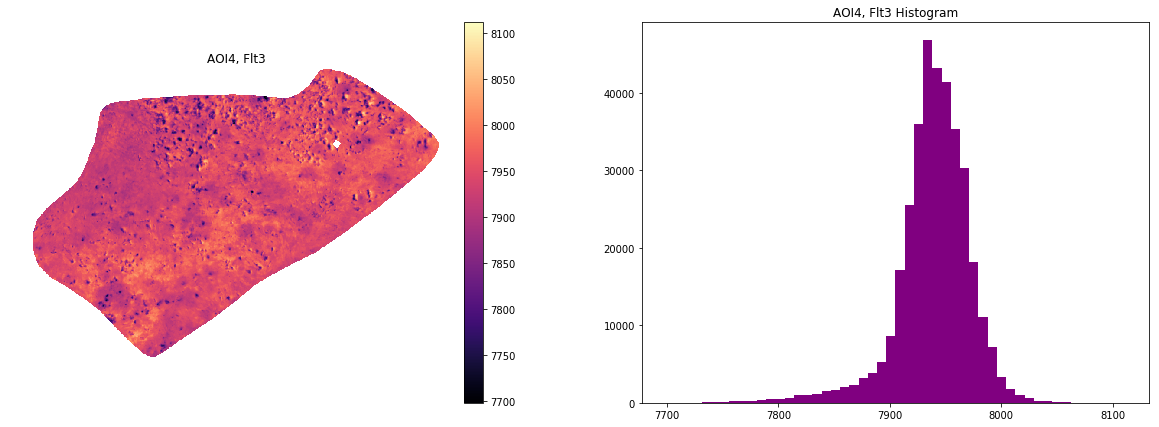

                 Value
Min.       7698.000000
Q1         7924.000000
Median     7942.000000
Q3         7959.000000
Max        8112.000000
Range       414.000000
IQ Range     35.000000
Mean       7939.029297
Std. Dev.    33.295422
Skewness     -1.283765
Kurtosis      4.530307


In [15]:
rasterSummary(aoi4[3], 'AOI4, Flt3')

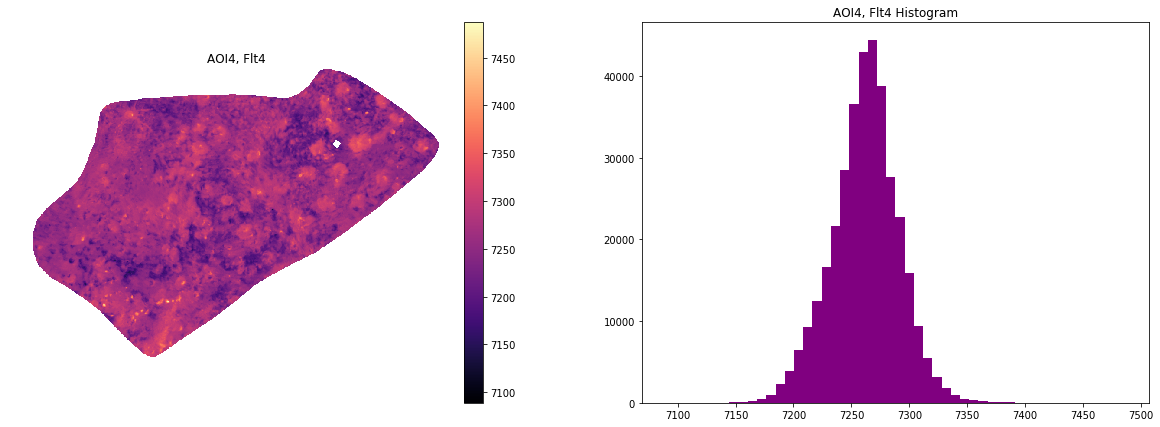

                 Value
Min.       7089.000000
Q1         7245.000000
Median     7264.000000
Q3         7280.000000
Max        7487.000000
Range       398.000000
IQ Range     35.000000
Mean       7262.106934
Std. Dev.    28.790655
Skewness     -0.091788
Kurtosis      0.651634


In [16]:
rasterSummary(aoi4[4], 'AOI4, Flt4')

### Create Pandas DataFrame for further exploration via pairwise plotting of each band

#### Flatten each band into a 1D array and remove null values

In [17]:
aoi4_flat = np.array([aoi4[band].flatten() for band in range(aoi4.shape[0])])

In [18]:
aoi4_flat.shape

(5, 623105)

In [19]:
aoi4_df = pd.DataFrame({'Flt'+str(b):aoi4_flat[b] for b in range(aoi4_flat.shape[0])})

In [20]:
aoi4_df.head()

,Flt0,Flt1,Flt2,Flt3,Flt4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [21]:
aoi4_df = aoi4_df.dropna().astype(dtype='int32')

In [22]:
aoi4_df.head()

,Flt0,Flt1,Flt2,Flt3,Flt4
1613,7036,7748,8256,7972,7267
1614,7037,7740,8254,7976,7267
1615,7037,7744,8246,7975,7272
1616,7044,7762,8238,7973,7270
1617,7041,7789,8232,7972,7267


In [23]:
aoi4_df.describe()

,Flt0,Flt1,Flt2,Flt3,Flt4
count,354064.000000,354064.000000,354064.000000,354064.000000,354064.000000
mean,7032.968991,7711.198523,8176.907054,7939.029890,7262.108218
std,19.279282,66.168755,50.918735,33.295466,28.790698
min,6938.000000,7296.000000,7788.000000,7698.000000,7089.000000
25%,7021.000000,7677.000000,8158.000000,7924.000000,7245.000000
50%,7032.000000,7717.000000,8184.000000,7942.000000,7264.000000
75%,7045.000000,7753.000000,8207.000000,7959.000000,7280.000000
max,7202.000000,8029.000000,8361.000000,8112.000000,7487.000000


### Pairwise plotting of 5 bands

C:\Users\samle\AppData\Local\ESRI\conda\envs\arcgispro-pyre\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


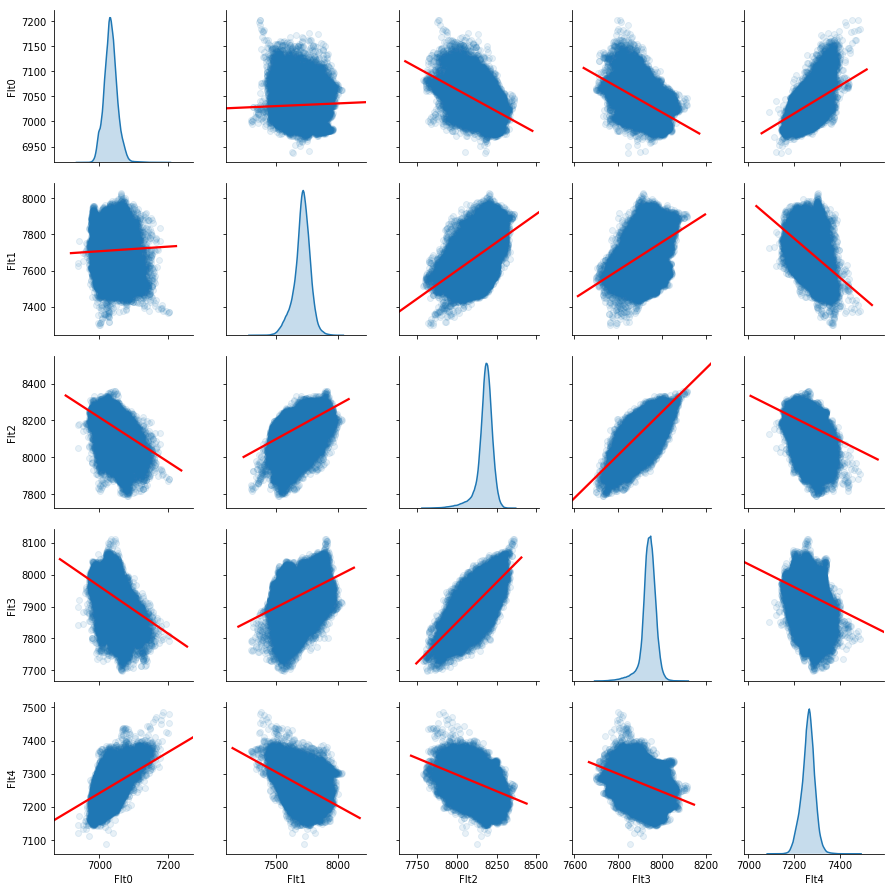

In [24]:
sns.pairplot(aoi4_df, kind='reg', diag_kind="kde", markers='o', plot_kws={'scatter_kws': {'alpha': 0.1}, 
                                                                          'line_kws': {'color': 'red'}})

### Correlatation matrix of 5 input bands

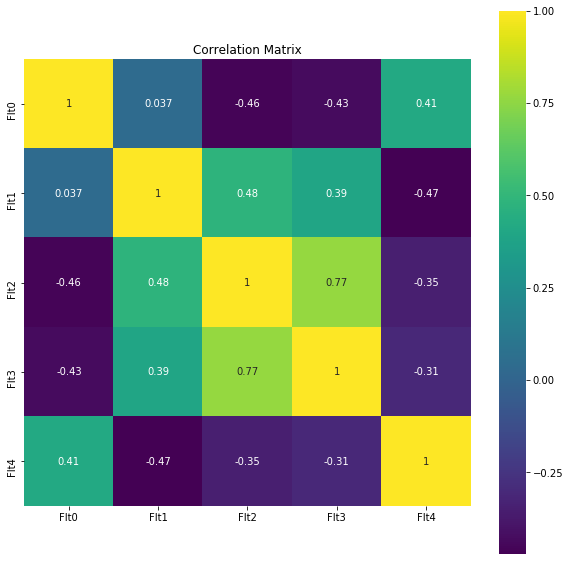

In [25]:
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(aoi4_df.corr(), annot=True, square=True, cmap='viridis')